<a href="https://colab.research.google.com/github/DSteinmann/HSG-AIML-CC/blob/AP/cc_01_getting_started(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="center" style="max-width: 900px; height: auto" src="../assets/banner.png">

###  Coding Challenge - Getting Started

<img align="right" style="max-width: 200px; height: auto" src="./hsg_logo.png">
<img align="center" style="max-width: 300px; height: auto" src="./sentinel2.jpg">

8,860,1.00 MCS Machine Learning, Spring Term 2025, University of St.Gallen (HSG)

The lab environment of the **8,860,1.00 Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this first lab, we want to touch on the basic concepts and techniques of such notebooks. Furthermore, its capabilities will be demonstrated based on a few simple and introductory examples.

### Objectives:

With the help of this notebook you should be able to:
    
> 1. Understand the basic funcitonality of the rasterio framework
> 2. Apply rasterio to load GTiff data
> 3. Visualize multi-band satellite imagery
> 4. Perform basic band arithmetic to compute the normalized difference vegetation index (NDVI)
> 5. Load and display samples from the challenge testset

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will use `os` and `glob` to collect the filepaths for the data samples, `numpy` for array operations, `matplotlib` to display images, and `rasterio` to handle raster data. You can find the documentation of the `rasterio` library with an overview of its functionality [here](https://rasterio.readthedocs.io).

In [ ]:


!pip install rasterio
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.1 MB/s eta 0:00:00


### Dataset Download
<img align="center" style="max-width: 300px; height: auto" src="./eurosat.png">

The Eurosat dataset is available on [github](https://github.com/phelber/EuroSAT). You can download and unpack the data from there. Note that this repository includes RGB and multi-spectral versions of Eurosat. Note that the testdata is multi-spectral.

The multi-spectral (MS) version can be downloaded with the following command:

In [ ]:


!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate



--2025-03-21 07:22:43--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  67.7MB/s    in 28s     

2025-03-21 07:23:11 (69.8 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
#unzip file
!unzip -q EuroSATallBands.zip

### Eurosat classes

The class-labels can be derived from the directory structure of the downloaded `zip` file. The 10 classes are as follows:

In [ ]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

### Data visualization
Let's define a function to visualize the Eurosat data with `matplotlib`. In the 13-band multispectral images of Sentinel-2, the 13 values of each pixel correspond to the reflectance values at different wavelengths. These numbers are not normalized for visualization with `matplotlib`, which expects inputs to be `int` in the `[0-255]` or `float` in the `[0.-1.]` range.

In [ ]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

## EuroSat Data Loading

First, let's collect all the files that we downloaded

In [ ]:
# change this to your eurosat path
eurosat_dir = "./ds/images/remote_sensing/otherDatasets/sentinel_2/tif"

In [ ]:
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

We have 27,000 files across 10 classes.

Let's load one of those multi-spectral images and try to visualize it.

In [ ]:
sample_idx = 1
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]

We can use `rasterio.open` to open the `GTiff` file. We can then `read` from the file. By default `read()` without arguments will load all bands. Individual bands can be specified as a list with one-based indices. Therefore, the RGB bands can be read with `read([4,3,2])`.

In [ ]:
with rio.open(sample, "r") as d:
    # img = d.read() # read all bands

    # read specific bands:
    # B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img.shape

(13, 64, 64)

We load the data into the `img` variable. This results in a `numpy` array with shape `(13,64,64)`, i.e. `CxHxW`. This differs from the convention of most image libraries like `matplotlib`, which work on image data in the `HxWxC` orientation. `rasterio` provides a function to easily fix this:

In [ ]:
img = reshape_as_image(img)
img.shape

(64, 64, 13)

Now let's normalize the data.

In [ ]:
normalized_img = normalize_for_display(img)

Finally, we can extract the RGB bands and visualize them with `matplotlib`.

In [ ]:
rgb_img = normalized_img[:, :, [3,2,1]]

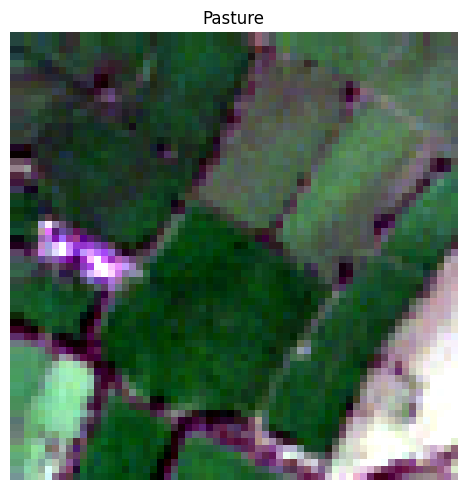

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"{label}")
ax.axis(False)
plt.tight_layout()

plt.show()

Note the `matplotlib` warning. Since we normalized the data by percentiles instead of maximum and minimum some (rare) pixels exceed the `[0.-1.]` range that `matplotlib` can handle. In such cases, the values are clipped to `1.`.

# Testset Data Loading

The testset has a slightly different structure than Eurosat. There are no labels and the data is stored in `numpy` `.npy` instead of GTiff.

First, we have to download the data from [Kaggle](https://www.kaggle.com/competitions/8-860-1-00-coding-challenge-2025/data).

In [ ]:
!pip install kaggle
!kaggle competitions download -c 8-860-1-00-coding-challenge-2025
#unzip
!unzip -q 8-860-1-00-coding-challenge-2025.zip

In [ ]:
testset_dir = os.path.join("./testset/", "testset")
test_samples = glob.glob(os.path.join(testset_dir, "*.npy"))
len(test_samples)

4232

Now let's visualize a sample as we did for Eurosat

In [ ]:
test_idx = 0

In [ ]:
test_img = np.load(test_samples[test_idx])
test_img.shape

(64, 64, 12)

Then normalize the data and extract RGB channels

In [ ]:
normalized_img = normalize_for_display(test_img)

In [ ]:
rgb_img = normalized_img[:, :, [3,2,1]]

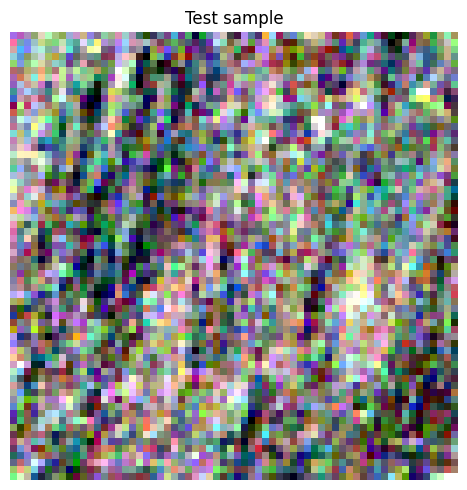

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"Test sample")
ax.axis(False)
plt.tight_layout()

plt.show()

### Bonus: Band arithmetic
The normalized difference vegetation index, or NDVI, is one of the most useful indices that can be derived from multi-spectral remote sensing data and indicates the presence of live green vegeation in an area.

> The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 to 1100 nm).

From [Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)

The NDVI exploits this difference in reflective properties of plants. It is computed as the ratio of the difference with the sum of near-infrared and red color bands. For the Sentinel2 data, this corresponds to the following:

`NDVI = (B8-B4)/(B8+B4)`

In [ ]:
sample = samples[10]
label = sample.split('/')[-1].split('_')[0]

with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img = reshape_as_image(img)
normalized_img = normalize_for_display(img)
rgb_img = normalized_img[:, :, [3,2,1]]

Extract bands 4 and 8 from the data.

In [ ]:
b8 = img[:, :, 7]
b4 = img[:, :, 3]

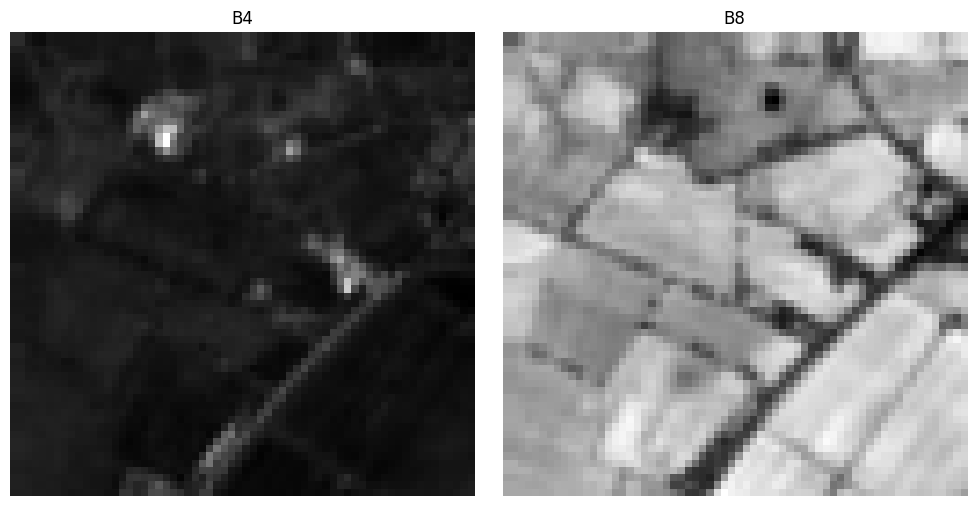

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(b4, cmap="gray")
axs[0].set_title("B4")
axs[0].axis(False)

axs[1].imshow(b8, cmap="gray")
axs[1].set_title("B8")
axs[1].axis(False)

plt.tight_layout()
plt.show()

Compute the NDVI:

In [ ]:
ndvi = (b8-b4) / (b8+b4)

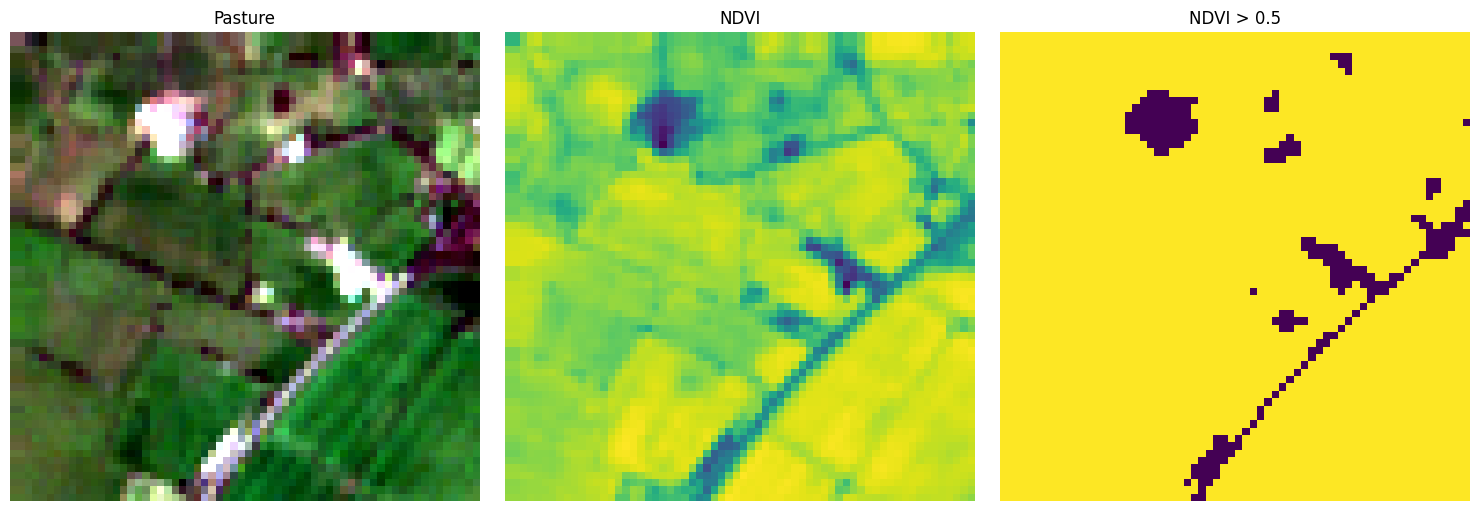

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.imshow(rgb_img)
ax1.set_title(f"{label}")
ax1.axis(False)

ax2.imshow(ndvi)
ax2.set_title(f"NDVI")
ax2.axis(False)

ax3.imshow(ndvi > .5)
ax3.set_title(f"NDVI > 0.5")
ax3.axis(False)

plt.tight_layout()
plt.show()

We can easily threshold NDVI values to obtain a segmentation mask of the vegetation in the image.

Let's also look at the bands individually.

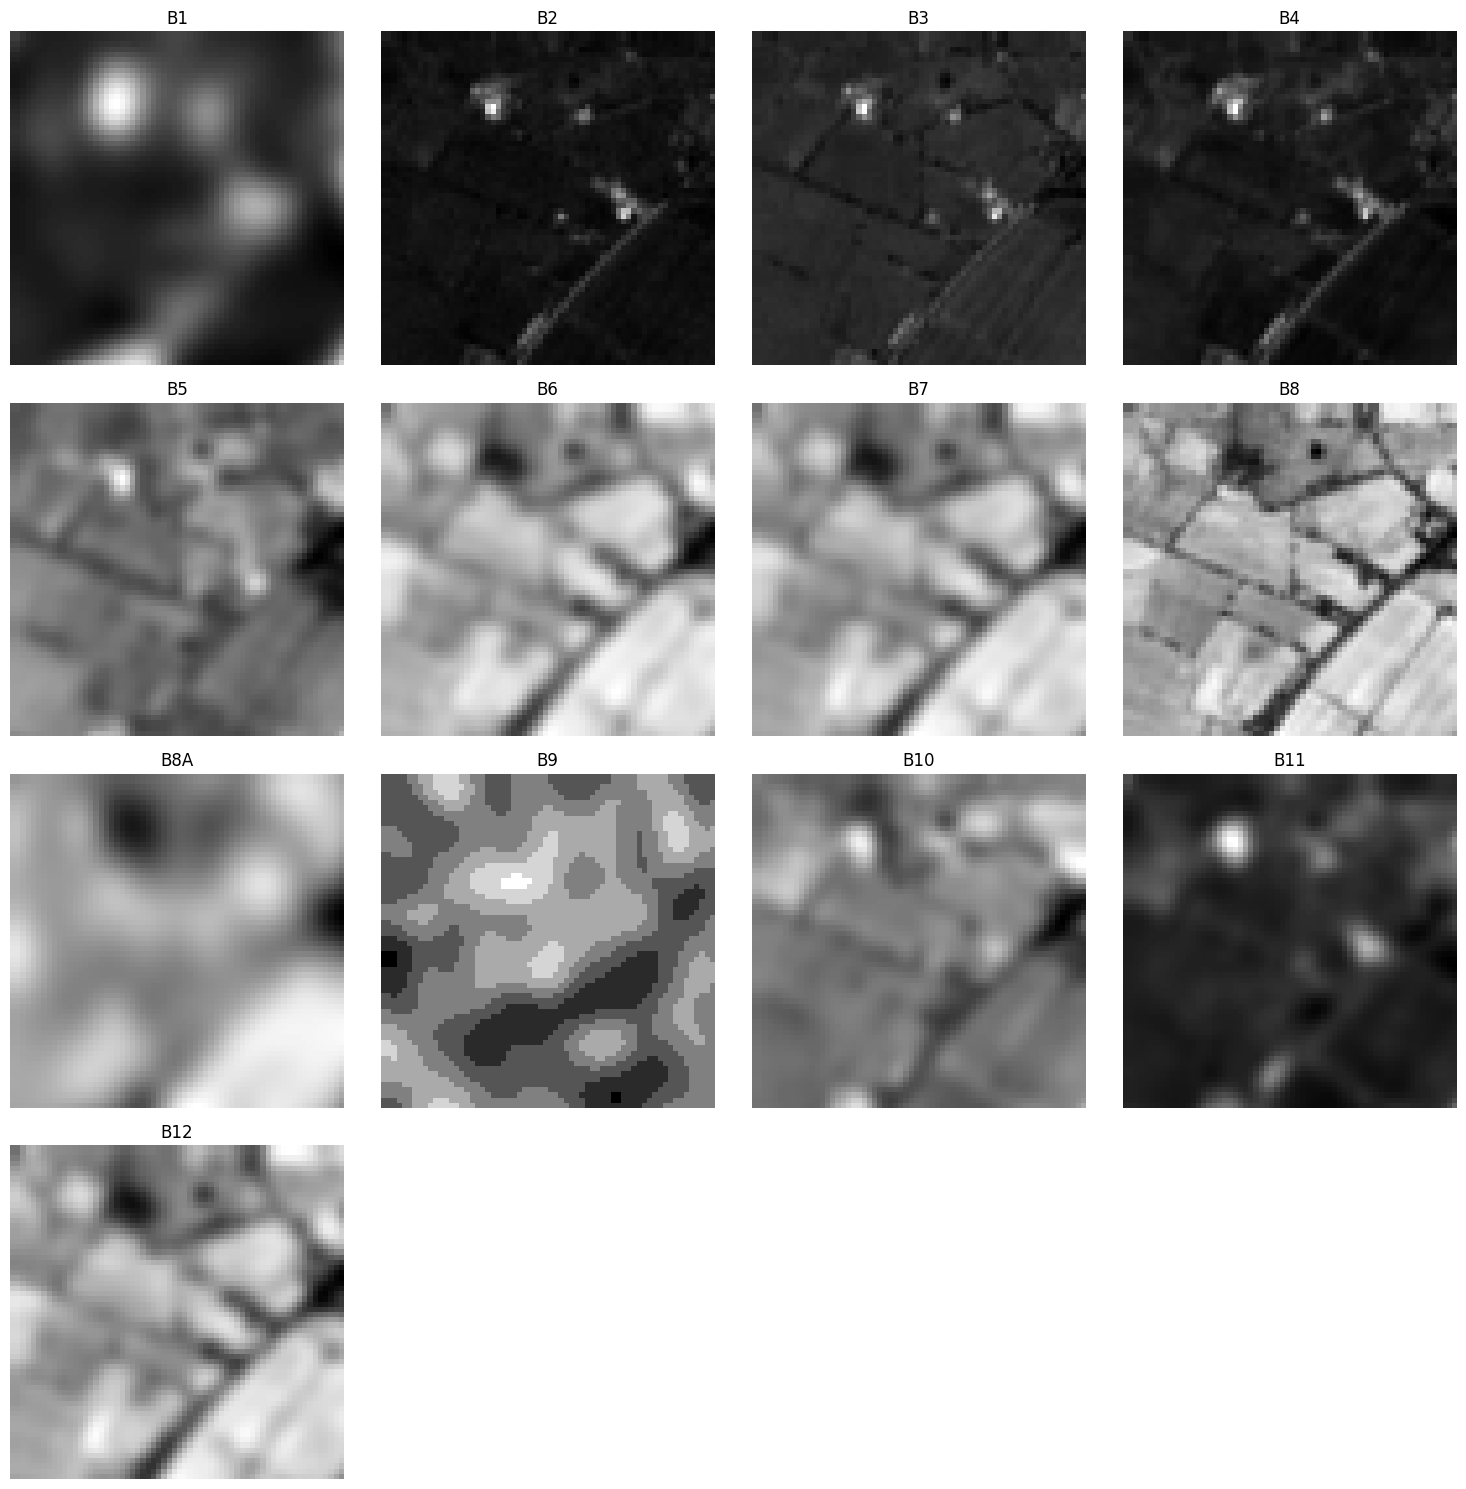

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

## Next steps

Create a (deep learning) model to predict the most likely Eurosat class for each image of the testset. Think about creating the dataset class and data-loader for training, possible model architectures, and perhaps even how to best address the shift between train and test data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

import glob
from PIL import Image
import rasterio as rio
from rasterio.plot import reshape_as_image



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from torchvision import transforms
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [ ]:
import os
import numpy as np
import tensorflow as tf
import rasterio as rio
from tensorflow import keras
from tensorflow.keras import layers
import torchvision.transforms as transforms

class EuroDataset:
    def __init__(self, data_dir, test_dir, bands_to_exclude=[10], img_size=(64, 64), batch_size=16, num_classes=10):
        self.data_dir = data_dir
        self.test_dir = test_dir
        self.bands_to_exclude = bands_to_exclude
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Compute mean and std dynamically after removing excluded bands
        self.mean_values, self.std_values = self.compute_mean_std()

        # Define transformations
        self.train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=30),
            transforms.RandomResizedCrop(size=self.img_size, scale=(0.8, 1.0)),
            transforms.Normalize(mean=self.mean_values, std=self.std_values)
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.Normalize(mean=self.mean_values, std=self.std_values)
        ])

    def compute_mean_std(self):
        """ Compute mean & std per band, ignoring excluded bands """
        means, stds = [], []
        num_images = 0

        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".tif"):
                    img_path = os.path.join(root, file)
                    with rio.open(img_path) as img:
                        img_array = img.read()  # Shape: (Bands, H, W)

                        # Remove excluded bands
                        img_array = np.delete(img_array, self.bands_to_exclude, axis=0)

                        means.append(np.mean(img_array, axis=(1, 2)))  # Per-band mean
                        stds.append(np.std(img_array, axis=(1, 2)))    # Per-band std
                        num_images += 1

        means = np.mean(np.stack(means), axis=0)
        stds = np.mean(np.stack(stds), axis=0)

        return means, stds

    def process_image(self, img_path):
        """ Load and process an image: remove excluded bands, resize, normalize """
        img_path = img_path.decode() if isinstance(img_path, bytes) else img_path
        with rio.open(img_path) as img:
            img_array = img.read()  # Shape: (Bands, H, W)

            # Remove B10
            img_array = np.delete(img_array, self.bands_to_exclude, axis=0)

            img_array = np.transpose(img_array, (1, 2, 0))  # Convert to (H, W, C)
            img_array = tf.image.resize(img_array, self.img_size)  # Resize
            img_array = (img_array - np.mean(img_array)) / np.std(img_array)  # Normalize

            # Enforce correct shape
            expected_channels = 12 - len(self.bands_to_exclude)
            img_array.set_shape([self.img_size[0], self.img_size[1], expected_channels])

        return img_array

    def data_generator(self):
        """ Generate training dataset """
        class_names = sorted(os.listdir(self.data_dir))
        file_paths, labels = [], []

        for class_idx, class_name in enumerate(class_names):
            class_path = os.path.join(self.data_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(class_path):
                file_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)

        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        def load_image(file_path, label):
            img = tf.py_function(lambda x: self.process_image(x.numpy()), [file_path], tf.float32)
            img.set_shape([self.img_size[0], self.img_size[1], 11])  # 11 bands after removing B10
            return img, tf.one_hot(label, self.num_classes)

        dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def load_test_data(self):
        """ Load test dataset (.npy format) """
        test_files = [os.path.join(self.test_dir, f) for f in os.listdir(self.test_dir) if f.endswith('.npy')]
        processed_images = []

        for file_path in test_files:
            data = np.load(file_path)  # Load .npy file

            # Remove excluded bands (assuming last dimension is channels)
            if data.shape[-1] > len(self.bands_to_exclude):
                data = np.delete(data, self.bands_to_exclude, axis=-1)
            else:
                raise ValueError(f"Invalid shape after band removal in {file_path}: {data.shape}")

            data = tf.image.resize(data, self.img_size)  # Resize
            data = (data - np.mean(data)) / np.std(data)  # Standardize

            # Convert to tensor and enforce correct shape
            data = tf.convert_to_tensor(data, dtype=tf.float32)
            data.set_shape([self.img_size[0], self.img_size[1], 11])  # 11 bands

            processed_images.append(data)

        test_dataset = tf.data.Dataset.from_tensor_slices(processed_images)
        test_dataset = test_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return test_dataset

class CNN:
    def __init__(self, input_shape=(64, 64, 11), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        """ Build CNN model """
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, train_dataset, epochs=1):
        """ Train the CNN model """
        return self.model.fit(train_dataset, epochs=epochs)

    def predict(self, test_dataset):
        """ Predict test dataset labels """
        y_pred = self.model.predict(test_dataset)
        return np.argmax(y_pred, axis=1)

# Define dataset paths
data_dir = "./ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
test_dir = "./testset/testset"

# Load dataset with B10 removed
dataset = EuroDataset(data_dir, test_dir)
train_dataset = dataset.data_generator()
test_dataset = dataset.load_test_data()

# Train model
cnn = CNN()
history = cnn.train(train_dataset, epochs=1)

# Predict test set
y_pred = cnn.predict(test_dataset)
print("Predictions:", y_pred)


In [ ]:
import torch                     #DAK MODEL
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
import rasterio
from collections import Counter
from sklearn.model_selection import train_test_split


# --- Setup ---
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001

train_dir = './ds/images/remote_sensing/otherDatasets/sentinel_2/tif'
validation_dir = './testset/testset'
model_save_path = 'standalone_resnet.pth'
predictions_csv_path = 'track_1.csv'



def normalize_image(image):
    # Common normalization logic here
    return (image - np.mean(image, axis=(1, 2), keepdims=True)) / (
                np.std(image, axis=(1, 2), keepdims=True) + 1e-7)


class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []

        for file in os.listdir(root_dir):
            if file.endswith('.npy'):
                self.file_paths.append(os.path.join(root_dir, file))
                # Assuming labels are not provided, assign a dummy label for now
                self.labels.append(0)  # Replace with actual labels if available

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)

        # Ensure data is in the correct format: [channels, height, width]
        if data.shape[0] != 12:  # Assuming 12 channels
            data = data.transpose((2, 0, 1))  # Convert to [channels, height, width]

        data = torch.from_numpy(data).float()

        # Normalize data if necessary
        data = normalize_image(data)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            data = self.transform(data)

        return data, label, os.path.basename(file_path)
# --- Custom Dataset ---
class Sentinel2Dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = [fp for fp in file_paths if os.path.exists(fp)]
        self.transform = transform
        self.labels = []

        # Assign labels based on file paths or other logic
        for file_path in self.file_paths:
            # Example logic to assign labels
            self.labels.append(0)  # Replace with actual label logic

        self.classes = sorted(list(set(self.labels)))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        # Load image from file_path
        image = rasterio.open(file_path).read()

        # Remove the 10th band (index 9 in zero-based indexing)
        image = np.delete(image, 9, axis=0)

        # Normalize the image
        image = (image - np.mean(image, axis=(1, 2), keepdims=True)) / (
                np.std(image, axis=(1, 2), keepdims=True) + 1e-7)

        image = torch.from_numpy(image).float()
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label, os.path.basename(file_path)
# --- Data Augmentation ---
train_transforms = transforms.Compose([
    transforms.Resize(1024),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.Normalize([0.485] * 12, [0.229] * 12)  # Ensure this matches your data's channels
])

val_transforms = transforms.Compose([
    transforms.Resize(1024),
    transforms.Normalize([0.485] * 12, [0.229] * 12)
])
# --- Create Datasets and DataLoaders ---

train_dataset = Sentinel2Dataset(train_dir, transform=train_transforms)
validation_dataset = NpyDataset(validation_dir)
file_paths = train_dataset.file_paths
labels = train_dataset.labels
unique_labels = sorted(list(set(labels)))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
labels = [label_to_idx[label] for label in labels]

# Now, file_paths and labels should have the same length
assert len(file_paths) == len(labels), "File paths and labels must have the same length"
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataset = Sentinel2Dataset(train_paths, transform=train_transforms)
validation_dataset_train = Sentinel2Dataset(val_paths, transform=val_transforms)



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset_train, batch_size=BATCH_SIZE, shuffle=False)
final_val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- Define Standalone ResNet-like Model ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = x + residual
        return self.relu(x)


class StandaloneResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        # ResNet-like layers
        self.layer1 = ResidualBlock(64, 128)  # Downsampling here
        self.layer2 = ResidualBlock(128, 256)  # Downsampling here
        self.layer3 = ResidualBlock(256, 512)  # Downsampling here
        self.layer4 = ResidualBlock(512, 1024)  # Downsampling here
        self.layer5 = ResidualBlock(1024, 2048)  # Downsampling here

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = StandaloneResNet(num_classes=len(train_dataset.classes))
model.to(DEVICE)
# --- Training Loop ---
# Calculate class frequencies
label_counts = Counter(train_dataset.labels)
total_samples = sum(label_counts.values())
class_frequencies = {label: count / total_samples for label, count in label_counts.items()}

# Convert class frequencies to class weights
class_weights = []
for label in sorted(train_dataset.class_to_idx.keys()):
    class_weights.append(1 / class_frequencies[train_dataset.class_to_idx[label]])

class_weights = torch.tensor(class_weights).to(DEVICE)  # Move class weights to GPU
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
patience = 5  # Number of epochs to wait before stopping
early_stopping_counter = 0
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss /= len(train_loader)
    accuracy = correct / total

    print(f"Epoch {epoch + 1} Train Loss: {epoch_loss:.4f}, Train Acc: {accuracy * 100:.2f}%")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(validation_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1} Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy * 100:.2f}%")

    if val_loss < best_val_loss and epoch > 1:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}!")
            break
# --- Save Predictions to CSV ---

# --- Prediction on Validation Set and Create CSV ---
all_predictions = []
all_filenames = []
best_model = StandaloneResNet(num_classes=len(train_dataset.classes))
best_model.load_state_dict(torch.load(model_save_path))
best_model.to(DEVICE)
best_model.eval()  # Set to evaluation mode

with torch.no_grad():
    for inputs, _, image_paths in final_val_loader:  # Get filenames!
        inputs = inputs.to(DEVICE)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Map numerical labels back to class names
        predicted_classes = [train_dataset.classes[pred.item()] for pred in predicted]
        all_predictions.extend(predicted_classes)
        all_filenames.extend([os.path.basename(path) for path in image_paths])  # Correct filename

# Create the DataFrame with 'test_id' and 'label'
predictions_df = pd.DataFrame({
    'test_id': [os.path.splitext(filename)[0] for filename in all_filenames],  # Extract filename
    'label': all_predictions
})

predictions_df.to_csv(predictions_csv_path, index=False)
print(f"Validation set predictions saved to: {predictions_csv_path}")

# --- Kaggle Submission (Requires API Key) ---
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()  # Make sure your kaggle.json is set up

kaggle_competition = 'your-competition-name'  # Replace with your actual competition name
kaggle_message = 'track_1'

df = pd.read_csv('track_1.csv')
df['test_id'] = df['test_id'].str.replace('test_', '', regex=False)

# Save the modified DataFrame back to the CSV file
df.to_csv('track_1.csv', index=False)
# Upload the CSV file to Kaggle
api.competition_submit(competition=kaggle_competition, file_name=predictions_csv_path, message=kaggle_message)

print(f"Submission uploaded to Kaggle: {kaggle_competition}")

In [ ]:
import torch              #RES2MODEL
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import models, transforms # Keep torchvision transforms
import rasterio
import numpy as np
import pandas as pd
import os
import random
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import ResNet50_Weights, ConvNeXt_Base_Weights
from sklearn.model_selection import train_test_split
import traceback

# --- Setup ---
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

# Define the paths
train_dir = './ds/images/remote_sensing/otherDatasets/sentinel_2/tif'
validation_dir = './testset/testset'
model_save_path = 'convnext_final_model.pth'
predictions_csv_path = 'track_2.csv'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using device: {DEVICE}")

# --- Configuration & Hyperparameters ---
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

best_image_size = 256
best_batch_size = 64
best_learning_rate = 1e-5
best_weight_decay =  3.7553e-05
best_optimizer_name = 'AdamW'

num_epochs = 100
warmup_epochs = 5
initial_warmup_lr = 1e-6
num_workers = 4
train_ratio = 0.9
patience = 10
num_classes = 10

# --- Normalization Stats (Defined as Tensors for transforms.Normalize) ---
print("Using predefined 12-channel normalization stats.")
train_mean_12ch = torch.tensor([1353.73, 1117.20, 1041.88, 946.55, 1199.19, 2003.01, 2374.01, 2301.22, 732.18, 1820.70, 1118.20, 2599.78], dtype=torch.float32)
train_std_12ch = torch.tensor([245.21, 327.28, 388.61, 586.99, 565.84, 859.51, 1085.12, 1108.11, 403.78, 1001.43, 759.43, 1229.73], dtype=torch.float32)
# Add epsilon for safety BEFORE passing to Normalize
train_std_12ch = torch.clamp(train_std_12ch, min=1e-7)


# --- Data Loading Function ---
def load_sentinel2_image(filepath):
    """Loads a Sentinel-2 image (12 bands), returns NumPy CHW."""
    if filepath.endswith('.tif'):
        with rasterio.open(filepath) as src:
            if src.count < 13: raise ValueError(f"Expected >=13 bands, got {src.count} in {filepath}")
            bands = list(range(1, 10)) + list(range(11, 14))
            image = src.read(bands) # Reads as (C, H, W)
    elif filepath.endswith('.npy'):
        image = np.load(filepath)
        if image.shape[0] == 13:
            image = np.concatenate((image[:9], image[10:]), axis=0) # (C, H, W)
        # Ensure CHW format if loaded as HWC
        if len(image.shape) == 3 and image.shape[0] != 12 and image.shape[2] == 12:
            image = image.transpose(2, 0, 1) # HWC -> CHW
        elif image.shape[0] != 12:
             raise ValueError(f"Unexpected shape for .npy {filepath}: {image.shape}")
    else:
        raise ValueError("Unsupported file type.")
    # NO normalization here, done in transforms now
    return image.astype(np.float32) # Ensure float32


# --- Dataset Class (Simplified __getitem__) ---
class Sentinel2Dataset(Dataset):
    """Custom Dataset for Sentinel-2 images. Returns Tensor CHW (12 channels)."""
    def __init__(self, paths_labels, transform=None): # Takes paths_labels directly
        self.paths_labels = paths_labels
        self.transform = transform
        # Get classes/mapping if this is the training dataset
        if isinstance(paths_labels[0][1], int): # Check if labels are indices
            unique_labels = sorted(list(set(l for _, l in paths_labels)))
            self.classes = [f"class_{i}" for i in unique_labels] # Placeholder names
            self.class_to_idx = {name: i for i, name in enumerate(self.classes)}


    def __len__(self):
        return len(self.paths_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_labels[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)

            # Convert to Tensor FIRST (Tensor CHW)
            image_tensor = torch.from_numpy(image_np).float()

            label_tensor = torch.tensor(label, dtype=torch.long)

            # Apply transforms (which now include Normalize)
            if self.transform:
                image_tensor = self.transform(image_tensor) # Pass the TENSOR

            return image_tensor, label_tensor, image_path

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None # Signal error

# --- Data Transforms (REVISED AGAIN - No ToTensor, Normalize uses 12ch stats) ---
train_transforms = transforms.Compose([
    # Input is already a 12-channel Tensor from __getitem__
    # Geometric augmentations work on multi-channel tensors
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.Resize((best_image_size, best_image_size), antialias=True), # Apply Resize
    # Cannot use ColorJitter, RandomResizedCrop easily on 12 channels here
    transforms.Normalize(mean=train_mean_12ch, std=train_std_12ch) # Use 12-channel stats
])

val_transforms = transforms.Compose([
    # Input is already a 12-channel Tensor from __getitem__
    transforms.Resize((best_image_size, best_image_size), antialias=True), # Resize
    transforms.Normalize(mean=train_mean_12ch, std=train_std_12ch) # Use 12-channel stats
])

# --- Create Datasets ---
print("Creating and splitting dataset...")
full_dataset_paths_labels = [] # Store (path, label_idx)
class_to_idx_map = {}
class_names = []
idx_counter = 0
# Scan training directory
for class_name in sorted(os.listdir(train_dir)):
     class_dir = os.path.join(train_dir, class_name)
     if os.path.isdir(class_dir) and not class_name.startswith('.'):
         if class_name not in class_to_idx_map:
             class_to_idx_map[class_name] = idx_counter
             class_names.append(class_name)
             idx_counter += 1
         class_idx = class_to_idx_map[class_name]
         for filename in os.listdir(class_dir):
             if filename.lower().endswith(('.tif', '.tiff')):
                 full_dataset_paths_labels.append((os.path.join(class_dir, filename), class_idx))

num_classes = len(class_names) # Update num_classes
print(f"Found {len(full_dataset_paths_labels)} training images in {num_classes} classes.")
print(f"Class names: {class_names}")


# Stratified Split
train_info, val_info = train_test_split(
    full_dataset_paths_labels,
    train_size=train_ratio,
    random_state=seed,
    stratify=[label for _, label in full_dataset_paths_labels]
)

# Create Dataset objects using the split lists
train_dataset = Sentinel2Dataset(train_info, transform=train_transforms)
train_dataset.classes = class_names # Manually assign class info if needed later
train_dataset.class_to_idx = class_to_idx_map

val_tif_dataset = Sentinel2Dataset(val_info, transform=val_transforms)
val_tif_dataset.classes = class_names
val_tif_dataset.class_to_idx = class_to_idx_map


# Validation dataset for FINAL evaluation (using .npy files)
class NpyPredictionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)
            # NO normalization on NumPy here

            image_tensor = torch.from_numpy(image_np).float() # Tensor (C, H, W)

            if self.transform:
                image_tensor = self.transform(image_tensor) # Apply val_transforms

            return image_tensor, 0, image_path # Dummy label 0

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None

final_validation_dataset = NpyPredictionDataset(validation_dir, transform=val_transforms)


# --- Create DataLoaders ---
def collate_fn(batch):
    """ Filter out None samples before creating batch """
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: return None, None, None
    images = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    paths = [item[2] for item in batch]
    return images, labels, paths

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=num_workers,
                          generator=torch.Generator().manual_seed(seed), pin_memory=True, collate_fn=collate_fn)
val_loader_split = DataLoader(val_tif_dataset, batch_size=best_batch_size, pin_memory=True, shuffle=False,
                              num_workers=num_workers, collate_fn=collate_fn)
final_pred_loader = DataLoader(final_validation_dataset, batch_size=best_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn)

print("DataLoaders created.")


# --- Model Definition (ConvNeXt adapted for 12->3 channels internally) ---
class ConvNeXtSentinel2(nn.Module):
    """ ConvNeXt model adapted for 12-channel input using an initial 1x1 conv. """
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # --- 1. Define the 1x1 Channel Projector ---
        self.channel_projector = nn.Conv2d(12, 3, kernel_size=1, bias=False)

        # --- 2. Load base ConvNeXt model ---
        self.convnext_base = models.convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT if pretrained else None)

        # --- 3. Initialize Projector Weights ---
        if pretrained:
            print("Initializing 1x1 channel projector weights...")
            with torch.no_grad():
                # Use spatially averaged weights from ResNet50 conv1 as a starting point
                try:
                    rn_weights = ResNet50_Weights.IMAGENET1K_V1.get_state_dict()['conv1.weight']
                    rn_weights_avg = rn_weights.mean(dim=[2, 3]) # Avg spatial dims -> [64, 3]
                    proj_weights = self.channel_projector.weight.data # [3, 12, 1, 1]
                    proj_weights.zero_()
                    for out_ch in range(3):
                        for in_ch in range(12):
                            source_out_ch = out_ch
                            source_in_ch = in_ch % 3
                            proj_weights[out_ch, in_ch, 0, 0] = rn_weights_avg[source_out_ch, source_in_ch]
                    print("Initialized conv1x1 using averaged ResNet weights.")
                except Exception as init_e:
                    print(f"Warning: Failed to initialize conv1x1 from ResNet ({init_e}). Using Kaiming init.")
                    nn.init.kaiming_normal_(self.channel_projector.weight, mode='fan_out', nonlinearity='relu')

        # --- 4. Store original components (if needed, but likely not) ---
        # self.features = self.convnext_base.features # Direct access might change
        # self.avgpool = self.convnext_base.avgpool
        # original_classifier = self.convnext_base.classifier

        # --- 5. Replace the classifier ---
        num_features_in = self.convnext_base.classifier[-1].in_features
        self.convnext_base.classifier = nn.Sequential(
             # Keep structure similar if needed (LayerNorm, Flatten)
             self.convnext_base.classifier[0], # LayerNorm
             self.convnext_base.classifier[1], # Flatten
             nn.Dropout(p=0.5),
             nn.Linear(num_features_in, num_classes)
        )
        print(f"Replaced classifier head for {num_classes} classes.")

        # --- 6. Initialize New Classifier Head ---
        nn.init.normal_(self.convnext_base.classifier[-1].weight, 0, 0.01)
        nn.init.zeros_(self.convnext_base.classifier[-1].bias)

        # --- 7. Set requires_grad for Fine-Tuning ---
        print("Configuring model for fine-tuning...")
        # Freeze everything initially
        for param in self.parameters():
            param.requires_grad = False
        # Unfreeze the projector, pre-classifier norm (if exists), and classifier
        for param in self.channel_projector.parameters(): # Unfreeze projector
            param.requires_grad = True
        for param in self.convnext_base.classifier.parameters(): # Unfreeze new classifier
            param.requires_grad = True

        # Unfreeze the last stage of the backbone
        if hasattr(self.convnext_base, 'features') and isinstance(self.convnext_base.features, nn.Sequential):
            last_stage_idx = -1
            for i in range(len(self.convnext_base.features) - 1, -1, -1):
                 if isinstance(self.convnext_base.features[i], (nn.Sequential, models.convnext.CNBlock)):
                     last_stage_idx = i
                     break
            if last_stage_idx != -1:
                for param in self.convnext_base.features[last_stage_idx].parameters():
                    param.requires_grad = True
                print(f"Unfroze channel_projector, classifier, and last stage (idx {last_stage_idx}).")
            else:
                 print("Unfroze channel_projector and classifier only.")


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. Project 12 channels to 3
        x = self.channel_projector(x)
        # 2. Pass through the *original* ConvNeXt base model's forward path
        x = self.convnext_base(x) # This will use the modified classifier internally
        return x


model = ConvNeXtSentinel2(num_classes=num_classes, pretrained=True) # Use the specific class
model.to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


# --- Loss Function, Optimizer, and Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer_params = filter(lambda p: p.requires_grad, model.parameters())
if best_optimizer_name.lower() == 'adamw':
    optimizer = torch.optim.AdamW(optimizer_params, lr=best_learning_rate, weight_decay=best_weight_decay)
elif best_optimizer_name.lower() == 'adam':
    optimizer = torch.optim.Adam(optimizer_params, lr=best_learning_rate, weight_decay=best_weight_decay)
else:
    raise ValueError(f"Invalid optimizer name: {best_optimizer_name}")

# Warmup Scheduler
if warmup_epochs > 0:
    warmup_steps_per_epoch = len(train_loader)
    total_warmup_steps = warmup_steps_per_epoch * warmup_epochs
    def lr_lambda(current_step):
        if current_step < total_warmup_steps:
            scale_factor = float(current_step + 1) / float(max(1, total_warmup_steps))
            lr_mult = initial_warmup_lr / best_learning_rate * (1.0 - scale_factor) + scale_factor
            return lr_mult
        return 1.0
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    print(f"Using linear warmup for {warmup_epochs} epochs ({total_warmup_steps} steps).")
else:
    warmup_scheduler = None

# Main epoch-level scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience // 2)

scaler = torch.amp.GradScaler(device=DEVICE.type, enabled=USE_CUDA) # Correct syntax

# --- Training Loop ---
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None

print("\n--- Starting Final Training ---")
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    for batch_idx, batch_data in enumerate(train_loader):
        if batch_data is None or batch_data[0] is None:
            # print(f"Warning: Skipping empty/invalid batch {batch_idx}") # Less verbose
            continue
        inputs, targets, _ = batch_data # Unpack correctly

        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad(set_to_none=True) # Use set_to_none=True

        with torch.amp.autocast(device_type=DEVICE.type, enabled=USE_CUDA):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Check for NaN loss before scaling/backward
        if torch.isnan(loss):
            print(f"WARNING: NaN loss detected at Epoch {epoch+1}, Batch {batch_idx+1}. Skipping batch.")
            optimizer.zero_grad() # Clear potentially bad gradients
            continue # Skip this batch

        scaler.scale(loss).backward()

        # Optional gradient clipping
        # scaler.unscale_(optimizer)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Step iteration-level scheduler (warmup phase)
        if warmup_scheduler and epoch < warmup_epochs:
             warmup_scheduler.step()

        # --- Accumulate ---
        total_train_loss += loss.item() * inputs.size(0) # Use inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += targets.size(0)
        correct_train_predictions += (predicted == targets).sum().item()

        if (batch_idx + 1) % 50 == 0: # Print less frequently
            print(f'  Train Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = total_train_loss / total_train_samples if total_train_samples > 0 else 0
    train_accuracy = 100. * correct_train_predictions / total_train_samples if total_train_samples > 0 else 0
    print(f'Epoch [{epoch + 1}/{num_epochs}] Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')

    # --- Validation (using val_loader_split with .tif files) ---
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch_data in val_loader_split: # Use the correct loader for internal val
            if batch_data is None or batch_data[0] is None:
                # print(f"Warning: Skipping empty/invalid validation batch") # Less verbose
                continue
            inputs, targets, _ = batch_data # Unpack

            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            with torch.amp.autocast(device_type=DEVICE.type, enabled=USE_CUDA): # Add autocast
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Check for NaN loss in validation (less likely but possible)
            if torch.isnan(loss):
                 print(f"WARNING: NaN loss detected during validation epoch {epoch+1}.")
                 continue

            total_val_loss += loss.item() * inputs.size(0) # Use inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += targets.size(0)
            correct_val_predictions += (predicted == targets).sum().item()

    # Check if validation happened at all
    if total_val_samples == 0:
        print("Warning: No valid validation samples processed in this epoch.")
        avg_val_loss = float('inf') # Assign high loss if no validation
        val_accuracy = 0.0
    else:
        avg_val_loss = total_val_loss / total_val_samples
        val_accuracy = 100. * correct_val_predictions / total_val_samples

    print(f'Epoch [{epoch + 1}/{num_epochs}] Avg Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

    # Step the EPOCH level scheduler AFTER the warmup phase
    if epoch >= warmup_epochs:
         scheduler.step(avg_val_loss) # Use validation loss

    current_lr = optimizer.param_groups[0]['lr'] # Get current LR
    print(f'Current LR: {current_lr:.6e}')

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, model_save_path) # Save the improved model
        print(f'---> Validation Loss Improved to {best_val_loss:.4f}, model saved.')
    else:
        epochs_without_improvement += 1
        print(f'---> Validation loss did not improve for {epochs_without_improvement} epochs.')
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            break

# --- After the loop ---
if best_model_state is not None:
    print(f'Best model saved during training to {model_save_path} with validation loss: {best_val_loss:.4f}')
    # Load the best model state back into the model for final prediction step
    model.load_state_dict(best_model_state)
else:
    print("Training finished without improvement or saving a model.")
    # Keep the last state if no improvement was ever made
    best_model = model # 'model' already holds the last state

print("Final training finished!")


# --- Final Prediction on Validation/Test Set (.npy files) and Create CSV ---
print("\n--- Generating predictions for submission ---")
# Ensure the best model weights are loaded
best_model_to_pred = ConvNeXtSentinel2(num_classes=num_classes, pretrained=False) # Recreate architecture
try:
    # Use weights_only=True for security when loading external/saved files
    best_model_to_pred.load_state_dict(torch.load(model_save_path, map_location=DEVICE, weights_only=True))
    print(f"Loaded best model weights from {model_save_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_save_path}. Using last model state if available.")
    if best_model_state is not None:
         best_model_to_pred.load_state_dict(best_model_state) # Use last saved best state
    else:
         print("WARNING: No best model state found, predicting with potentially untrained model!")
         best_model_to_pred = model # Use the model from end of training

best_model_to_pred.to(DEVICE)
best_model_to_pred.eval() # Set to evaluation mode

all_predictions = []
all_filenames = []

with torch.no_grad():
    for batch_data in final_pred_loader: # Use the loader with .npy files
        if batch_data is None or batch_data[0] is None:
            print(f"Warning: Skipping empty/invalid prediction batch")
            continue
        inputs, _, image_paths = batch_data # Get filenames!

        inputs = inputs.to(DEVICE)
        with torch.amp.autocast(device_type=DEVICE.type, enabled=USE_CUDA):
            outputs = best_model_to_pred(inputs) # Use the loaded best model
        _, predicted = torch.max(outputs, 1)

        # Use class names defined earlier based on training data folders
        predicted_classes = [class_names[pred.item()] for pred in predicted]
        all_predictions.extend(predicted_classes)
        all_filenames.extend([os.path.basename(path) for path in image_paths])


# Create the DataFrame with 'test_id' and 'label'
predictions_df = pd.DataFrame({
    'test_id': [os.path.splitext(filename)[0] for filename in all_filenames],
    'label': all_predictions
})

predictions_csv_path = "_track2.csv" # Ensure correct submission filename
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"Submission predictions saved to: {predictions_csv_path}")